--2025-08-28 12:27:18--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/e42c2500-9016-11ea-92ba-11df9f79f31b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-28T13%3A20%3A25Z&rscd=attachment%3B+filename%3Dyolov3.weights&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-28T12%3A20%3A20Z&ske=2025-08-28T13%3A20%3A25Z&sks=b&skv=2018-11-09&sig=OcxAg3lfROrrlqLHT958WkortImlDWjmgEwa%2B5za5Lk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjM4NDMzOCwibmJmIjoxNzU2Mzg0MDM4LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJ

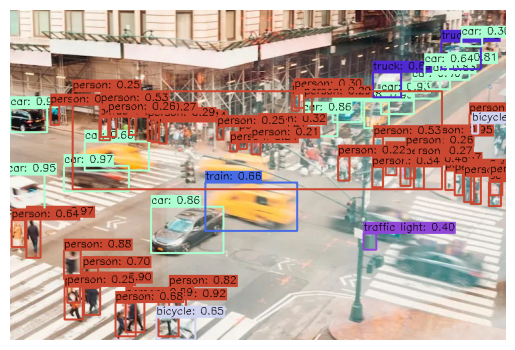

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

print("Downloading YOLOv3 files...")
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
!wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
!wget https://github.com/pjreddie/darknet/raw/master/data/coco.names
print("Download complete.")

weights_path = "yolov3.weights"
cfg_path = "yolov3.cfg"
names_path = "coco.names"

if os.path.exists(weights_path + ".1"):
    os.rename(weights_path + ".1", weights_path)
if os.path.exists(cfg_path + ".1"):
    os.rename(cfg_path + ".1", cfg_path)
if os.path.exists(names_path + ".1"):
    os.rename(names_path + ".1", names_path)

print("Loading class names...")
def load_names(names_path):
    with open(names_path, "r") as f:
        return [c.strip() for c in f.readlines()]
classes = load_names(names_path)
print(f"Loaded {len(classes)} class names.")

print("Loading YOLOv3 network...")
try:
    net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
    print("YOLOv3 network loaded successfully.")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU backend.")

    def get_output_layer_names(net):
        layer_names = net.getLayerNames()
        output_layers = []
        for i in net.getUnconnectedOutLayers():
            if isinstance(i, list):
                output_layers.append(layer_names[i[0] - 1])
            else:
                output_layers.append(layer_names[i - 1])
        return output_layers

    output_layers = get_output_layer_names(net)

except Exception as e:
    print(f"Error loading YOLOv3 network: {e}")
    exit()

image_path = "/content/busy-junction-full-cars-people_23-2148184362.webp"
print(f"Loading image: {image_path}")
img = cv2.imread(image_path)

if img is None:
    print(f"Error: Image not found at {image_path}. Please upload the image or change the path.")
    exit()

h, w = img.shape[:2]
print(f"Image loaded with dimensions: {w}x{h}")

input_size = 608
blob = cv2.dnn.blobFromImage(img, 1/255.0, (input_size, input_size), swapRB=True, crop=False)
net.setInput(blob)

print("Performing forward pass...")
outputs = net.forward(output_layers)
print("Forward pass complete.")

boxes, confidences, class_ids = [], [], []
for out in outputs:
    for det in out:
        scores = det[5:]
        class_id = int(np.argmax(scores))
        conf = float(scores[class_id])
        conf_thresh = 0.2
        if conf > conf_thresh:
            cx, cy, bw, bh = det[:4] * np.array([w, h, w, h])
            x, y = int(cx - bw/2), int(cy - bh/2)
            boxes.append([x, y, int(bw), int(bh)])
            confidences.append(conf)
            class_ids.append(class_id)

nms_thresh = 0.4
print(f"Found {len(boxes)} raw detections. Applying NMS...")
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh)
print(f"After NMS, {len(idxs)} detections remaining.")

font = cv2.FONT_HERSHEY_SIMPLEX
colors = np.random.uniform(0, 255, size=(len(classes), 3))

print("Drawing bounding boxes and labels...")
if len(idxs) > 0:
    for i in np.array(idxs).flatten():
        x, y, bw, bh = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x+bw, y+bh), color, 2)
        (text_width, text_height) = cv2.getTextSize(label, font, fontScale=0.5, thickness=1)[0]
        text_offset_x = x
        text_offset_y = y - 5
        cv2.rectangle(img, (text_offset_x, text_offset_y - text_height), (text_offset_x + text_width, text_offset_y + 5), color, cv2.FILLED)
        cv2.putText(img, label, (text_offset_x, text_offset_y), font, 0.5, (0,0,0), 1)

print("Visualization complete.")

save_path = "results.png"
cv2.imwrite(save_path, img)
print("Saved:", save_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


#When would grayscaling be a bad idea? Name a detection task
#where color is the most important feature. (e.g., identifying traffic
#light status, sorting ripe vs. unripe fruit).


Grayscaling would be a bad idea when we need to differentiate between objects on bais of colour for example if two cars are involved in a car chase where car 1 is chase it and car2 is being chased both having different colour if the video/image is convereted in to grayscale then we wont be able to differentiate between the 2 so in shirt in situations where colour is a deciding factor grayscaling would be a bad idea.





#Blurring intentionally destroys information. Imagine you are building a
#system to read license plates from a security camera. How could blurring be
#helpful? How could it be harmful if you apply too much?

If we have too much noise in our images then blurring would be a great option with the help of the we can remove the noise. but a lot of blurring would  reuslt in feature loss thus making object detection a difficult task.


#What is the trade-off of resizing? If you shrink an image of a
#crowded street too much to make it faster, what critical information
#might you lose?
If we shrink an image of crowded street we might lose info of people in the street leading to less distinction among them. thus making hard for our object detection alogrithm detect objects and differentiate between them.

